In [1]:
import pandas as pd
import json
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt 
import geopandas as gpd
import re
from unicodedata import normalize
%matplotlib inline

In [2]:
shapefile = gpd.read_file("provincias\provincias.shp")
shapefile.head()

,gml_id,COD_DEP,NOM_DEP,COD_PROV,NOM_PROV,geometry
0,provincias.1,None,Potosi,14,Daniel Campos,(POLYGON ((-67.77305347523615 -19.950290823121...
1,provincias.2,0,LAGO,None,Lago Poopo,POLYGON ((-67.06019150600909 -18.4484522815948...
2,provincias.3,0,LAGO,None,Lago Titicaca,POLYGON ((-69.3216493012208 -15.54774582814021...
3,provincias.4,0,LAGO,None,Lago Uru Uru,POLYGON ((-67.10087293362919 -18.0256358100023...
4,provincias.5,0,SALAR,None,Salar de Coipasa,POLYGON ((-67.9834848260208 -19.03681753326408...


In [3]:
shapefile["Centroides"] =  shapefile.geometry.centroid

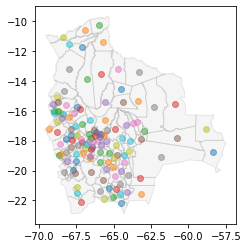

In [4]:
ax = shapefile.plot(color ="gray", alpha=0.08,edgecolor="black")
for p in shapefile.Centroides.values:
    plt.scatter(p.x, p.y, alpha = 0.5)

In [5]:
loc_provincia = shapefile[['gml_id', 'COD_DEP', 'NOM_DEP', 'COD_PROV', 'NOM_PROV','Centroides']]

In [6]:
loc_provincia.NOM_DEP.unique()
PROV_BOL = loc_provincia[loc_provincia.NOM_DEP.isin(['Potosi', 'Chuquisaca', 'La Paz', 'Cochabamba',
       'Oruro', 'Tarija', 'Santa Cruz', 'Beni', 'Pando'])]

PROV_BOL[PROV_BOL.COD_DEP.isin(['01','1', '2', '3', '4', '5', '6', '7', '8','9'])].groupby("NOM_DEP").count()
#+ PROV_BOL.COD_PROV

,gml_id,COD_DEP,COD_PROV,NOM_PROV,Centroides
NOM_DEP,,,,,
Beni,8,8,8,8,8
Chuquisaca,11,11,11,11,11
Cochabamba,16,16,16,16,16
La Paz,19,19,19,19,19
Oruro,16,16,16,16,16
Pando,5,5,5,5,5
Potosi,17,17,17,17,17
Santa Cruz,15,15,15,15,15
Tarija,6,6,6,6,6


# Extrayendo las actas por Provincias

In [7]:
actas = pd.read_excel("acta.2019.10.25.21.09.30.xlsx")

actasPres = actas[actas.Elección == 'Presidente y Vicepresidente']

actasPres["ValidosBienSumados"] = actasPres[['CC',
       'FPV', 'MTS', 'UCS', 'MAS - IPSP', '21F', 'PDC', 'MNR', 'PAN-BOL']].sum(axis=1)

VotosPorProvincias = actasPres.groupby(['País','Departamento',
                   'Provincia']).agg({"CC":"sum", 'MAS - IPSP':"sum",
                                                    'FPV' : "sum", 'MTS' : "sum", 
                                                   'UCS': "sum", '21F' : "sum", 
                                                   'PDC': "sum", 'MNR': "sum", 'PAN-BOL' : "sum",
                                                   "ValidosBienSumados": "sum"})
VotosPorProvincias.reset_index(inplace = True)
VotosPorProvincias.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,País,Departamento,Provincia,CC,MAS - IPSP,FPV,MTS,UCS,21F,PDC,MNR,PAN-BOL,ValidosBienSumados
0,Alemania,Berlín,Berlín,164,42,0,3,0,0,1,1,2,213
1,Argentina,Buenos Aires,Berazategui,49,1085,3,4,2,15,50,3,2,1213
2,Argentina,Buenos Aires,Buenos Aires,4782,25383,74,327,152,323,1983,96,304,33424
3,Argentina,Buenos Aires,Chacabuco,9,193,0,0,0,1,10,1,3,217
4,Argentina,Buenos Aires,Escobar,71,1201,5,8,13,6,88,5,2,1399
5,Argentina,Buenos Aires,Esteban Echeverría,132,3171,12,20,145,15,238,5,21,3759
6,Argentina,Buenos Aires,General Pueyrredón,27,440,2,2,5,9,24,4,6,519
7,Argentina,Buenos Aires,Ituzaingó,128,976,2,27,7,10,52,4,10,1216
8,Argentina,Buenos Aires,José M. Ezeiza,4,266,0,1,0,4,29,1,0,305
9,Argentina,Buenos Aires,La Matanza,1199,15177,34,106,55,117,961,34,107,17790


In [8]:
plt.rcParams['figure.figsize'] = (10, 10)

# Obteniendo la localizaciòn de los municipios en base a la ultimà informaciòn disponible. 
## Cobertura de servicios financieros ASFI 2019

In [9]:
df_places = gpd.read_file('Servicios_Financieros_ASFI31082019.geojson')

In [10]:
df_places.drop(df_places[(df_places.COD_INE.astype(str).str[:-6]== "")].index,inplace=True) # Excluyendo salares y lagos

In [11]:
# Estandarizando nombres de provincias
def EstandarizarNombres(s):
    """
    s : string a estandarizar
    Se estandariza eliminando los carateres especiales y tildes, pasando todo a mayúsculas
    """
    return normalize("NFC",re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", s), 0, re.I) ).upper().replace("SUD ","SUR ")

In [12]:
loc_provincia["NOM_DEP"] = loc_provincia.NOM_DEP.apply(EstandarizarNombres)
loc_provincia["NOM_PROV"] = loc_provincia.NOM_PROV.apply(EstandarizarNombres)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
df_places["COD_INE_XXYY"] = df_places.COD_INE.astype(str).str[:-4]

In [14]:
dic_provincias = df_places.groupby("COD_INE_XXYY").max()[["DEPARTAMEN","PROVINCIA"]].reset_index()
dic_provincias["Depto_sinAjuste"] = dic_provincias.DEPARTAMEN
dic_provincias["Prov_sinAjuste"] = dic_provincias.PROVINCIA 
dic_provincias["DEPARTAMEN"] = dic_provincias.DEPARTAMEN.apply(EstandarizarNombres)
dic_provincias["PROVINCIA"] = dic_provincias.PROVINCIA.apply(EstandarizarNombres)
dic_provincias.head()

,COD_INE_XXYY,DEPARTAMEN,PROVINCIA,Depto_sinAjuste,Prov_sinAjuste
0,101,CHUQUISACA,OROPEZA,Chuquisaca,Oropeza
1,102,CHUQUISACA,AZURDUY,Chuquisaca,Azurduy
2,103,CHUQUISACA,ZUDAÑEZ,Chuquisaca,Zudáñez
3,104,CHUQUISACA,TOMINA,Chuquisaca,Tomina
4,105,CHUQUISACA,HERNANDO SILES,Chuquisaca,Hernando Siles


In [15]:
dic_provinciasActas = actasPres.groupby(["Departamento","Provincia"]).agg({"Municipio":"count"}).reset_index()
dic_provinciasActas["Depto_sinAjuste"] = dic_provinciasActas.Departamento
dic_provinciasActas["Prov_sinAjuste"] = dic_provinciasActas.Provincia 
dic_provinciasActas["Departamento"] = dic_provinciasActas.Departamento.apply(EstandarizarNombres)
dic_provinciasActas["Provincia"] = dic_provinciasActas.Provincia.apply(EstandarizarNombres)
dic_provinciasActas["Provincia"] = dic_provinciasActas.Provincia.str.replace("O' ","O'")
dic_provinciasActas["Provincia"] = dic_provinciasActas.Provincia.str.replace("BERNARDINO ","")
dic_provinciasActas.head()

,Departamento,Provincia,Municipio,Depto_sinAjuste,Prov_sinAjuste
0,ACRE,BRASILEA,1,Acre,Brasilea
1,ANDALUCIA,GRANADA,4,Andalucia,Granada
2,ANDALUCIA,MALAGA,2,Andalucia,Málaga
3,ANDALUCIA,SEVILLA,16,Andalucia,Sevilla
4,ANTOFAGASTA,ANTOFAGASTA,30,Antofagasta,Antofagasta


In [16]:
DIC_TOTAL = pd.merge(dic_provincias, dic_provinciasActas, how="left", left_on=["DEPARTAMEN","PROVINCIA"], right_on=["Departamento","Provincia"])
DIC_TOTAL

,COD_INE_XXYY,DEPARTAMEN,PROVINCIA,Depto_sinAjuste_x,Prov_sinAjuste_x,Departamento,Provincia,Municipio,Depto_sinAjuste_y,Prov_sinAjuste_y
0,101,CHUQUISACA,OROPEZA,Chuquisaca,Oropeza,CHUQUISACA,OROPEZA,1091,Chuquisaca,Oropeza
1,102,CHUQUISACA,AZURDUY,Chuquisaca,Azurduy,CHUQUISACA,AZURDUY,57,Chuquisaca,Azurduy
2,103,CHUQUISACA,ZUDAÑEZ,Chuquisaca,Zudáñez,CHUQUISACA,ZUDAÑEZ,78,Chuquisaca,Zudañez
3,104,CHUQUISACA,TOMINA,Chuquisaca,Tomina,CHUQUISACA,TOMINA,91,Chuquisaca,Tomina
4,105,CHUQUISACA,HERNANDO SILES,Chuquisaca,Hernando Siles,CHUQUISACA,HERNANDO SILES,102,Chuquisaca,Hernando Siles
...,...,...,...,...,...,...,...,...,...,...
107,901,PANDO,NICOLAS SUAREZ,Pando,Nicolás Suárez,PANDO,NICOLAS SUAREZ,221,Pando,Nicolas Suarez
108,902,PANDO,MANURIPI,Pando,Manuripi,PANDO,MANURIPI,56,Pando,Manuripi
109,903,PANDO,MADRE DE DIOS,Pando,Madre de Dios,PANDO,MADRE DE DIOS,72,Pando,Madre de Dios
110,904,PANDO,ABUNA,Pando,Abuná,PANDO,ABUNA,15,Pando,Abuna


# Análisis de votos por provincias

In [17]:
ActasProv = (pd.merge(actasPres, DIC_TOTAL, how="left", left_on=["Departamento","Provincia"], 
                     right_on= ["Depto_sinAjuste_y","Prov_sinAjuste_y"]).
                            groupby(["País", 'Depto_sinAjuste_y','Prov_sinAjuste_y']).
                                    agg({"CC":"sum", 'MAS - IPSP':"sum",
                                                    'FPV' : "sum", 'MTS' : "sum", 
                                                   'UCS': "sum", '21F' : "sum", 
                                                   'PDC': "sum", 'MNR': "sum", 'PAN-BOL' : "sum",
                                                   "ValidosBienSumados": "sum", 
                                                     'COD_INE_XXYY': "max",
                                                    'Depto_sinAjuste_x' : "max",
                                                       'Prov_sinAjuste_x': "max" , 
                                                     #  'Depto_sinAjuste_y' : "max",
                                                     #   'Prov_sinAjuste_y' : "max"})
                                        })).reset_index()

In [18]:
ActasProv[ ActasProv.País == "Bolivia"] .columns

Index(['País', 'Depto_sinAjuste_y', 'Prov_sinAjuste_y', 'CC', 'MAS - IPSP',
       'FPV', 'MTS', 'UCS', '21F', 'PDC', 'MNR', 'PAN-BOL',
       'ValidosBienSumados', 'COD_INE_XXYY', 'Depto_sinAjuste_x',
       'Prov_sinAjuste_x'],
      dtype='object')

In [19]:
# ActasProv[ActasProv.País == "Bolivia"]
#( 2 - loc_provincia.COD_DEP.str.len()).fillna(0) 
v = lambda x : "0"*(2-len(str(x))) + str(x)
loc_provincia.loc[10,"COD_DEP"] = "2"
loc_provincia.loc[6,"COD_DEP"] = "1"
loc_provincia["COD_INE_XXYY"] = (loc_provincia.COD_DEP + loc_provincia.COD_PROV.apply(v))
# loc_provincia.drop(83,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [20]:
B = pd.merge(ActasProv[ ActasProv.País == "Bolivia"], loc_provincia, how ="left", 
on="COD_INE_XXYY")
B.head()

,País,Depto_sinAjuste_y,Prov_sinAjuste_y,CC,MAS - IPSP,FPV,MTS,UCS,21F,PDC,...,ValidosBienSumados,COD_INE_XXYY,Depto_sinAjuste_x,Prov_sinAjuste_x,gml_id,COD_DEP,NOM_DEP,COD_PROV,NOM_PROV,Centroides
0,Bolivia,Beni,Cercado,25315,22460,211,433,233,14662,6124,...,71100,801,Beni,Cercado,provincias.111,8,BENI,1,CERCADO,POINT (-64.49120326848605 -14.54291732161241)
1,Bolivia,Beni,General José Ballivián,9543,15597,167,308,192,5222,2446,...,35741,803,Beni,General José Ballivián,provincias.113,8,BENI,3,GENERAL JOSE BALLIV,POINT (-66.81497866348113 -13.87053835424301)
2,Bolivia,Beni,Iténez,1323,3757,13,42,18,3340,259,...,9228,808,Beni,Iténez,provincias.118,8,BENI,8,ITENEZ,POINT (-63.31751397770437 -13.41595801350658)
3,Bolivia,Beni,Mamore,841,1854,10,12,6,1668,119,...,4886,807,Beni,Mamoré,provincias.117,8,BENI,7,MAMORE,POINT (-64.713271398823 -13.18825756666413)
4,Bolivia,Beni,Marban,920,3565,41,109,48,1008,555,...,6433,806,Beni,Marbán,provincias.116,8,BENI,6,MARBAN,POINT (-64.39582763976713 -15.42933435097598)


## Generar mapas por partido a nivel provincias

Text(0.6, 0.091, ' *El tamaño de los puntos indica el la cantidad de votos válidos emitidos\nen esa provincia, frente al total')

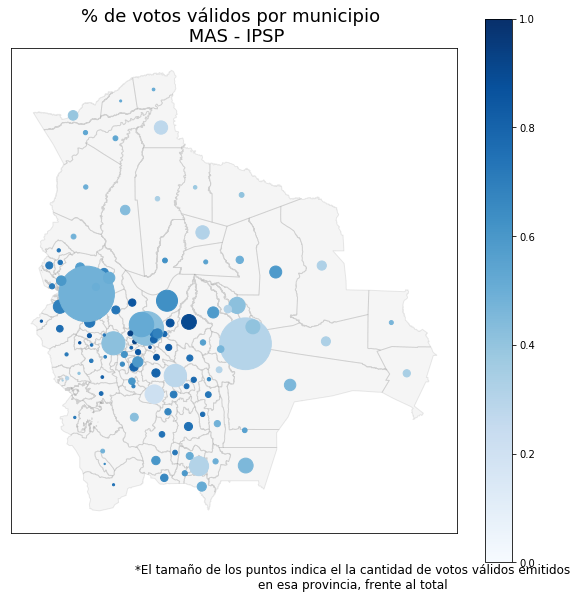

In [21]:
partido = "MAS - IPSP"
ax = shapefile.plot(color ="gray", alpha=0.08,edgecolor="black")

plt.scatter(B.Centroides.apply(lambda x : x.x),
            B.Centroides.apply(lambda x : x.y),
            s= (B.ValidosBienSumados/sum(B.ValidosBienSumados) )*15000, 
            c=  B[partido]/B["ValidosBienSumados"], cmap = plt.cm.Blues)

plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.clim(0,1)
plt.title("% de votos válidos por municipio \n {}".format(partido), size=18)
plt.figtext(0.6, 0.091, """ *El tamaño de los puntos indica el la cantidad de votos válidos emitidos
en esa provincia, frente al total""", wrap=True, horizontalalignment='center', fontsize=12)

## Generar mapa partidos ganadores por provincias

In [22]:
pos_ganador = B[['CC', 'MAS - IPSP', 'FPV', 'MTS', 'UCS', '21F',
                'PDC', 'MNR', 'PAN-BOL']].apply(lambda x: x.values.argmax() , axis = 1 )

B_0 = B[pos_ganador ==0 ]
B_1 = B[pos_ganador ==1 ]

Text(0.6, 0.061, ' *El tamaño de los puntos indica el la cantidad de votos válidos emitidos\nen esa provincia, frente al total')

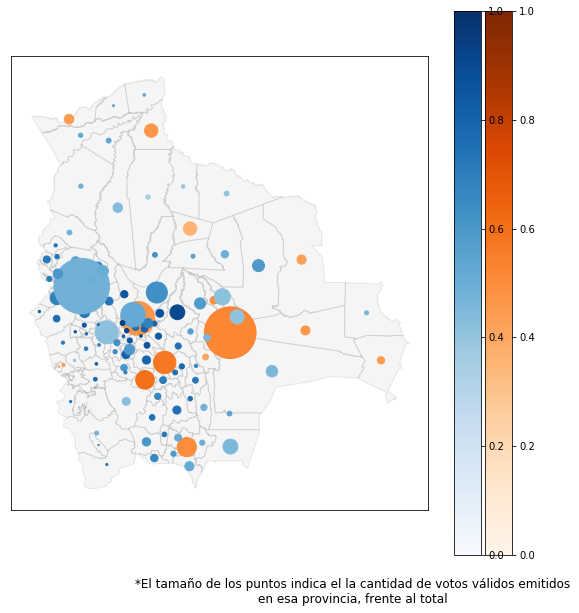

In [23]:
ax = shapefile.plot(color ="gray", alpha=0.08,edgecolor="black")

plt.scatter(B_0.Centroides.apply(lambda x : x.x),
            B_0.Centroides.apply(lambda x : x.y),
            s= (B_0.ValidosBienSumados/sum(B.ValidosBienSumados) )*15000, 
            c=  B_0["CC"]/B_0["ValidosBienSumados"], cmap = plt.cm.Oranges)
plt.colorbar(pad = -0.085)
plt.clim(0,1)

plt.scatter(B_1.Centroides.apply(lambda x : x.x),
            B_1.Centroides.apply(lambda x : x.y),
            s= (B_1.ValidosBienSumados/sum(B.ValidosBienSumados) )*15000, 
            c=  B_1["MAS - IPSP"]/B_1["ValidosBienSumados"], cmap = plt.cm.Blues)


plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.clim(0,1)

plt.figtext(0.6, 0.061, """ *El tamaño de los puntos indica el la cantidad de votos válidos emitidos
en esa provincia, frente al total""", wrap=True, horizontalalignment='center', fontsize=12)


# Análisis de votos por municipio

In [24]:
actas_cod = pd.merge(actasPres, DIC_TOTAL, how="left", left_on=["Departamento","Provincia"], 
                     right_on= ["Depto_sinAjuste_y","Prov_sinAjuste_y"])

actas_cod.columns

Index(['País', 'Número departamento', 'Departamento_x', 'Provincia_x',
       'Número municipio', 'Municipio_x', 'Circunscripción', 'Localidad',
       'Recinto', 'Número Mesa', 'Código Mesa', 'Elección', 'Inscritos', 'CC',
       'FPV', 'MTS', 'UCS', 'MAS - IPSP', '21F', 'PDC', 'MNR', 'PAN-BOL',
       'Votos Válidos', 'Blancos', 'Nulos', 'Estado acta',
       'ValidosBienSumados', 'COD_INE_XXYY', 'DEPARTAMEN', 'PROVINCIA',
       'Depto_sinAjuste_x', 'Prov_sinAjuste_x', 'Departamento_y',
       'Provincia_y', 'Municipio_y', 'Depto_sinAjuste_y', 'Prov_sinAjuste_y'],
      dtype='object')

In [25]:
actas_cod["cod_mun"] = actas_cod.COD_INE_XXYY.str.upper() + actas_cod['Número municipio'].apply(v)

In [26]:
actas_MUN = actas_cod.groupby(['País', 'Departamento_x', 'Provincia_x','Municipio_x',]).agg({"CC":"sum", 'MAS - IPSP':"sum",
                                                    'FPV' : "sum", 'MTS' : "sum", 
                                                   'UCS': "sum", '21F' : "sum", 
                                                   'PDC': "sum", 'MNR': "sum", 'PAN-BOL' : "sum",
                                                   "ValidosBienSumados": "sum", 
                                                     'cod_mun': "max",
                                                    'Depto_sinAjuste_x' : "max",
                                                       'Prov_sinAjuste_x': "max" }).reset_index()
actas_MUN.head()

,País,Departamento_x,Provincia_x,Municipio_x,CC,MAS - IPSP,FPV,MTS,UCS,21F,PDC,MNR,PAN-BOL,ValidosBienSumados,cod_mun,Depto_sinAjuste_x,Prov_sinAjuste_x
0,Alemania,Berlín,Berlín,Berlín,164,42,0,3,0,0,1,1,2,213,NaN,NaN,NaN
1,Argentina,Buenos Aires,Berazategui,Berazategui,49,1085,3,4,2,15,50,3,2,1213,NaN,NaN,NaN
2,Argentina,Buenos Aires,Buenos Aires,C.A. Buenos Aires,4782,25383,74,327,152,323,1983,96,304,33424,NaN,NaN,NaN
3,Argentina,Buenos Aires,Chacabuco,Chacabuco,9,193,0,0,0,1,10,1,3,217,NaN,NaN,NaN
4,Argentina,Buenos Aires,Escobar,Escobar,71,1201,5,8,13,6,88,5,2,1399,NaN,NaN,NaN


In [27]:
df_places["cod_mun"] = df_places.COD_INE.astype(str).str[:-2]
C = pd.merge(actas_MUN[actas_MUN.País == "Bolivia"], df_places, how="left", on= "cod_mun")
C.head()

,País,Departamento_x,Provincia_x,Municipio_x,CC,MAS - IPSP,FPV,MTS,UCS,21F,...,COD_INE,DEPARTAMEN,PROVINCIA,MUNICIPIO,CAPITAL,PAF,CODIGO,CLASIFICAC,geometry,COD_INE_XXYY
0,Bolivia,Beni,Cercado,San Javier,252,797,5,13,10,382,...,80102.0,Beni,Cercado,San Javier,San Javier,0.0,N,Nula Cobertura,(POLYGON ((-65.04075267942976 -14.739253033011...,801
1,Bolivia,Beni,Cercado,Trinidad,25063,21663,206,420,223,14280,...,80101.0,Beni,Cercado,Trinidad,Trinidad,38.0,A,Alta Cobertura,(POLYGON ((-63.97501202196727 -14.728386463618...,801
2,Bolivia,Beni,General José Ballivián,Puerto Menor de Rurrenabaque,2371,4092,35,56,35,1746,...,80304.0,Beni,General José Ballivián,Puerto Menor de Rurrenabaque,Rurrenabaque,8.0,A,Alta Cobertura,(POLYGON ((-67.35071364454784 -14.385736426568...,803
3,Bolivia,Beni,General José Ballivián,Reyes,2071,1689,14,31,18,543,...,80301.0,Beni,General José Ballivián,Reyes,Reyes,2.0,B,Baja Cobertura,(POLYGON ((-66.62194129340459 -12.022819470982...,803
4,Bolivia,Beni,General José Ballivián,San Borja,3543,8390,86,189,106,2270,...,80302.0,Beni,General José Ballivián,San Borja,San Borja,11.0,M,Media Cobertura,(POLYGON ((-66.5210714500604 -14.3107281893025...,803


In [28]:
C[ C.geometry.isnull()] # Se identificó el gobierno autónomo indigena originario

,País,Departamento_x,Provincia_x,Municipio_x,CC,MAS - IPSP,FPV,MTS,UCS,21F,...,COD_INE,DEPARTAMEN,PROVINCIA,MUNICIPIO,CAPITAL,PAF,CODIGO,CLASIFICAC,geometry,COD_INE_XXYY
81,Bolivia,Cochabamba,Mizque,Raqaypampa,22,2806,27,9,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
X_vec = []
Y_vec = []
for i in C.geometry: 
    try : 
        X_vec.append(i.centroid.x)
        Y_vec.append(i.centroid.y)
    except :
        # Imputando la localización del territorio Autónomo indígena
        X_vec.append(-65.382364)
        Y_vec.append(-18.189171)

## Generando mapa por partido a nivel municipal

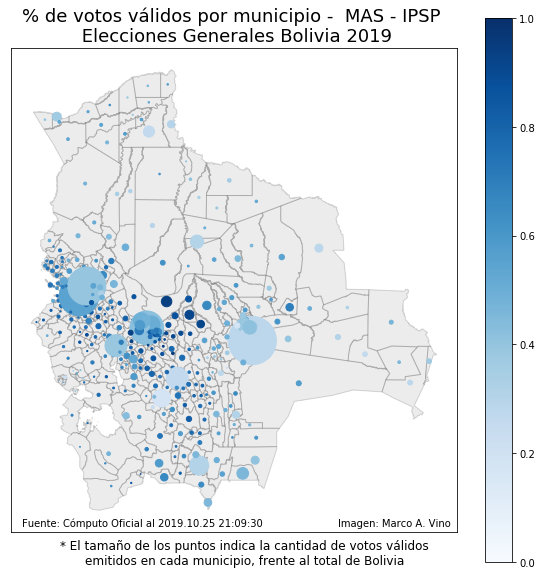

In [37]:
partido = "MAS - IPSP"
ax = df_places.plot(color ="gray", alpha=0.15,edgecolor="black")

plt.scatter(X_vec,       Y_vec,
            s= (C.ValidosBienSumados/sum(C.ValidosBienSumados) )*15000, 
            c=  C[partido]/C["ValidosBienSumados"], cmap = plt.cm.Blues)

plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.clim(0,1)

plt.title("% de votos válidos por municipio -  {} \n Elecciones Generales Bolivia 2019".format(partido), size=18)
plt.figtext(0.45, 0.125, """ * El tamaño de los puntos indica la cantidad de votos válidos
emitidos en cada municipio, frente al total de Bolivia""", wrap=True, horizontalalignment='center', fontsize=12)

plt.figtext(0.14 ,0.175,"Fuente: Cómputo Oficial al 2019.10.25 21:09:30",  horizontalalignment='left', fontsize=10)

plt.figtext(0.58 ,0.175,"Imagen: Marco A. Vino",  horizontalalignment='left', fontsize=10)


plt.savefig("Partido_{}".format(partido), dpi=500)

## Generando el mapa de partidos ganadores por municipio

In [31]:
pos_ganador = C[['CC', 'MAS - IPSP', 'FPV', 'MTS', 'UCS', '21F',
                'PDC', 'MNR', 'PAN-BOL']].apply(lambda x: x.values.argmax() , axis = 1 )

pos_ganador.value_counts()

1    289
0     48
5      3
dtype: int64

In [32]:
C_0 = C[pos_ganador ==0 ] # CC
C_1 = C[pos_ganador ==1 ] # MAS- IPSP
C_5 = C[pos_ganador ==5 ] # 21F

In [33]:
# Se extraen los puntos de referencia por municipio  
X_vec_1 = []
Y_vec_1 = []
for i in C_1.geometry: 
    try : 
        X_vec_1.append(i.centroid.x)
        Y_vec_1.append(i.centroid.y)
    except :
        print(i)
        X_vec_1.append(-65.382364)
        Y_vec_1.append(-18.189171)

X_vec_0 = []
Y_vec_0 = []
for i in C_0.geometry: 
    X_vec_0.append(i.centroid.x)
    Y_vec_0.append(i.centroid.y)

X_vec_5 = []
Y_vec_5 = []
for i in C_5.geometry: 
    X_vec_5.append(i.centroid.x)
    Y_vec_5.append(i.centroid.y)


nan


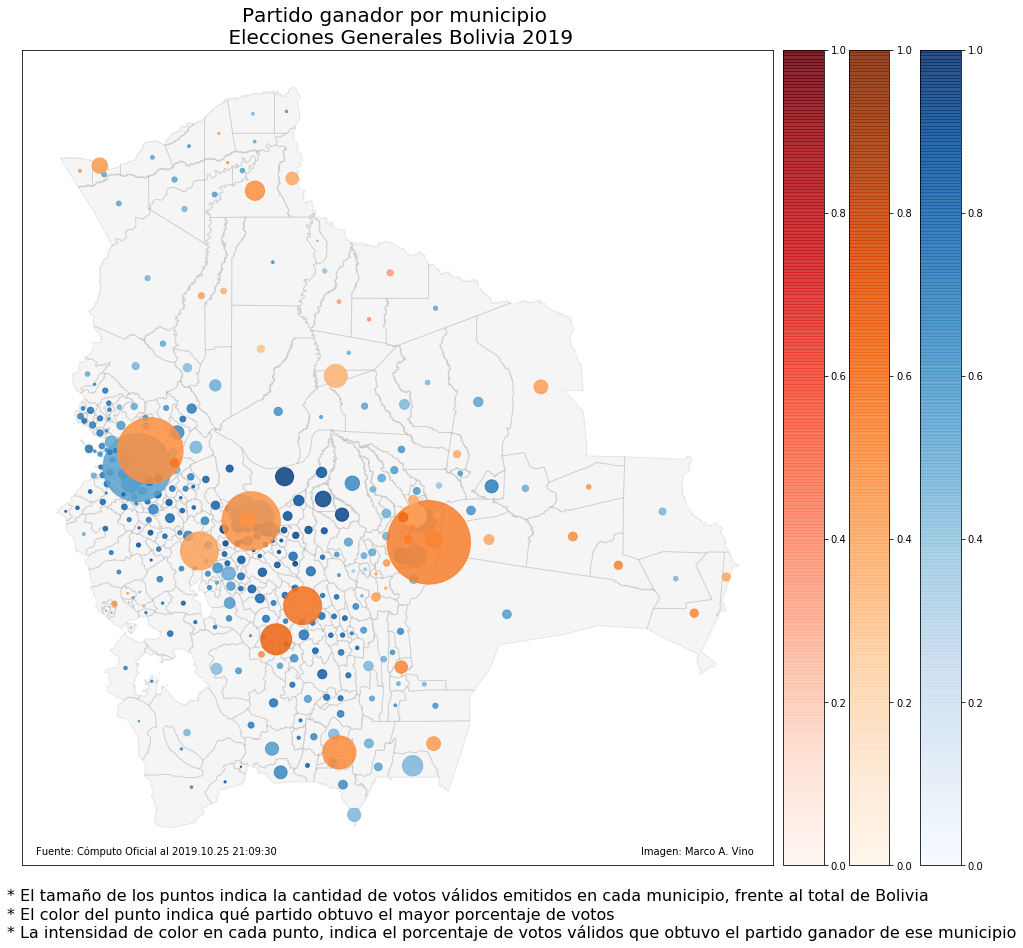

In [34]:
factor = 45000
a = 0.85
ax = df_places.plot(color ="gray", alpha=0.08,edgecolor="black", figsize=(20, 15))

plt.scatter(X_vec_1, Y_vec_1,
            s= (C_1.ValidosBienSumados/sum(B.ValidosBienSumados) )*factor, 
            c=  C_1["MAS - IPSP"]/C_1["ValidosBienSumados"], cmap = plt.cm.Blues, alpha=a)
plt.colorbar(pad= -0.075)
plt.clim(0,1)

plt.scatter(X_vec_0, Y_vec_0, 
            s= (C_0.ValidosBienSumados/sum(B.ValidosBienSumados) )*factor, 
            c=  C_0["CC"]/C_0["ValidosBienSumados"], cmap = plt.cm.Oranges, alpha=a)
plt.colorbar(pad= -0.075)
plt.clim(0,1)


plt.scatter(X_vec_5, Y_vec_5,
            s= (C_5.ValidosBienSumados/sum(B.ValidosBienSumados) )*factor, 
            c=  C_5["MAS - IPSP"]/C_5["ValidosBienSumados"], cmap = plt.cm.Reds, alpha=a)
plt.xticks([])
plt.yticks([])
plt.colorbar(pad= 0.01)
plt.clim(0,1)

plt.title("Partido ganador por municipio \n Elecciones Generales Bolivia 2019",size=20)

plt.figtext(0.15, 0.06, """ * El tamaño de los puntos indica la cantidad de votos válidos emitidos en cada municipio, frente al total de Bolivia
* El color del punto indica qué partido obtuvo el mayor porcentaje de votos
* La intensidad de color en cada punto, indica el porcentaje de votos válidos que obtuvo el partido ganador de ese municipio""", wrap=True, horizontalalignment='left', fontsize=16)

plt.figtext(0.17 ,0.135,"Fuente: Cómputo Oficial al 2019.10.25 21:09:30",  horizontalalignment='left', fontsize=10)

plt.figtext(0.59 ,0.135,"Imagen: Marco A. Vino",  horizontalalignment='left', fontsize=10)

plt.savefig("PorPartido.png" , dpi = 500)